# Recomendación Usuario-Item

Crear un sistema de recomendación donde la entrada sea un usuario, identifique usuarios similares y recomiende juegos basados en las preferencias de esos usuarios. La entrada es un usuario, y la salida es una lista de juegos recomendados para ese usuario. Para lograr esto, se utilizará la similitud del coseno.

### Importamos las librerías

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

### Lectura del archivo CSV

In [75]:
user_items = pd.read_csv('..\\Datsets\\CSV\\user_items.csv')
user_reviews = pd.read_csv('..\\Datsets\\CSV\\user_reviews.csv')

Columnas necesarias: user_id, items_count, item_id, item_name, playtime_forever y recommend.

Realizamos un "left join" porque no todos los usuarios que están en el DataFrame de user_items han hecho recomendaciones.

In [76]:
#Concatenamos los dataframes
df_usuario_item = pd.merge(user_items, user_reviews[['user_id', 'recommend']], on='user_id', how='left')

# Seleccionar las columnas deseadas
df_usuario_item = df_usuario_item[['user_id', 'items_count', 'item_id', 'item_name', 'playtime_forever', 'recommend']]

In [77]:
df_usuario_item.head()

,user_id,items_count,item_id,item_name,playtime_forever,recommend
0,76561197970982479,277,10,Counter-Strike,6,True
1,76561197970982479,277,10,Counter-Strike,6,True
2,76561197970982479,277,10,Counter-Strike,6,True
3,76561197970982479,277,20,Team Fortress Classic,0,True
4,76561197970982479,277,20,Team Fortress Classic,0,True


Necesitamos agrupar por user_id e item_name. Dado que la columna items_count se repite para cada usuario, utilizaremos el primer valor. La columna playtime_forever se sumará por juego y por user_id. Similarmente, la columna recommend se manejará de la misma manera que item_name.

In [78]:
# Agrupar por user_id, item_name y mantener las columnas necesarias
df_usuario_item = df_usuario_item.groupby(['user_id', 'item_name']).agg({
    'items_count': 'first',  #  usar 'first' para mantener un valor único
    'playtime_forever': 'sum',
    'recommend': 'first'  # Similar a 'items_count', selecciona el primer valor
}).reset_index()

In [79]:
df_usuario_item.head()

,user_id,item_name,items_count,playtime_forever,recommend
0,--000--,ACE - Arena: Cyber Evolution,58,0,True
1,--000--,APB Reloaded,58,2763,True
2,--000--,AdVenture Capitalist,58,0,True
3,--000--,Apotheon Arena,58,74,True
4,--000--,BLOCKADE 3D,58,445,True


Creamos un DataFrame que consta de dos columnas: la primera columna almacena el user_id y la segunda columna contiene listas de juegos recomendados por ese usuario. Este DataFrame resultará útil cuando trabajemos con el DataFrame de usuarios similares, permitiendo la concatenación de la información del usuario con sus respectivas recomendaciones de juegos.

In [80]:
# Rellenar los valores nulos en la columna 'recommend' con False
df_usuario_item['recommend'] = df_usuario_item['recommend'].fillna(False)

# Filtrar solo las filas con recommend igual a True
df_usuario_recomendaciones = df_usuario_item[df_usuario_item['recommend']]

# Agrupar por user_id y agregar una lista de juegos recomendados
df_usuario_recomendaciones = df_usuario_recomendaciones.groupby('user_id').agg({'item_name': list}).reset_index()

In [81]:
df_usuario_recomendaciones.head()

,user_id,item_name
0,--000--,"[ACE - Arena: Cyber Evolution, APB Reloaded, A..."
1,--ace--,"[8BitBoy, AdVenture Capitalist, BattleBlock Th..."
2,--ionex--,"[Another World, Call of Duty: Modern Warfare 2..."
3,-2SV-vuLB-Kg,"[16 Bit Arena, 16bit Trader, A grande bagun√ßa..."
4,-Azsael-,"[Amnesia: A Machine for Pigs, Anno 2070, Arcan..."


## Preprocesamiento de los Datos

Para determinar la similitud entre usuarios, utilizaremos las columnas `items_count` y `playtime_forever`. Agruparemos por `user_id` para conocer la cantidad de juegos que tiene cada usuario y cuánto ha jugado en total.

In [82]:
# Agrupar por user_id
df_user_item_ML = df_usuario_item.groupby(['user_id']).agg({
    'items_count': 'first',  # Mantenemos un valor único
    'playtime_forever': 'sum',
}).reset_index()

In [83]:
df_user_item_ML.head()

,user_id,items_count,playtime_forever
0,--000--,58,141027
1,--ace--,44,140764
2,--ionex--,23,96168
3,-2SV-vuLB-Kg,68,271245
4,-404PageNotFound-,149,231260


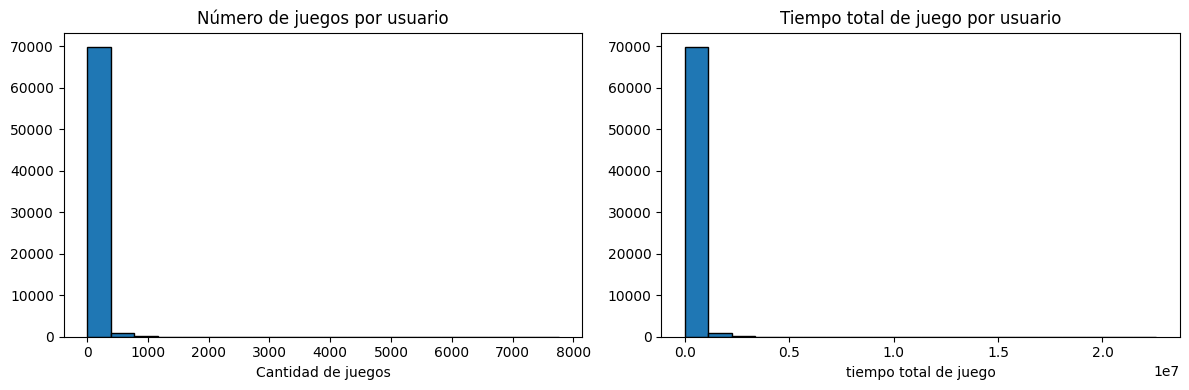

In [67]:
# Crear subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Histograma de 'items_count'
axs[0].hist(df_user_item_ML['items_count'], bins=20, edgecolor='black')
axs[0].set_title('Número de juegos por usuario')
axs[0].set_xlabel('Cantidad de juegos')
axs[0].set_ylabel('')

# Histograma de 'playtime_forever'
axs[1].hist(df_user_item_ML['playtime_forever'], bins=20, edgecolor='black')
axs[1].set_title('Tiempo total de juego por usuario')
axs[1].set_xlabel('tiempo total de juego')
axs[1].set_ylabel('')

# Ajustar diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

En el histograma, se evidencia que el rango de ambas columnas es considerablemente amplio. Para abordar esta variabilidad, se optará por aplicar una transformación logarítmica. Esta elección se basa en la capacidad de la transformación logarítmica para comprimir intervalos, aprovechando además que las variables en cuestión, items_count y playtime_forever, no pueden contener valores negativos. 

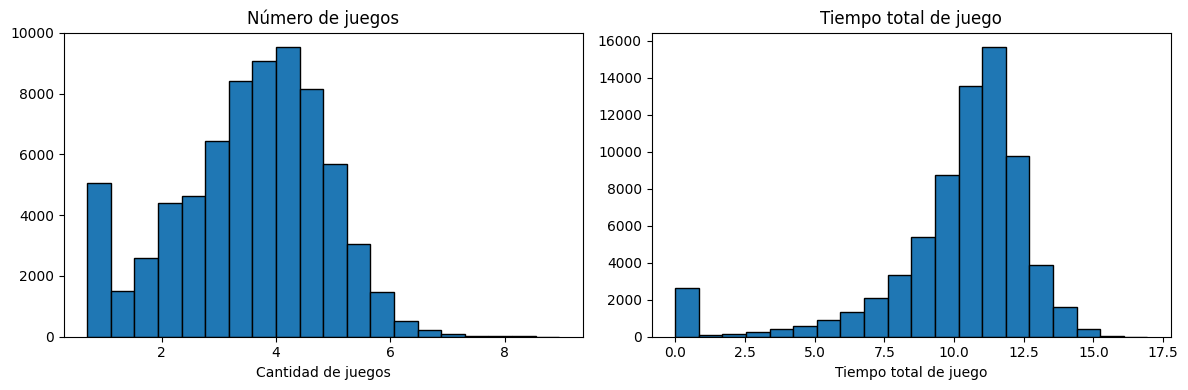

In [68]:
# Aplicar transformación logarítmica a las columnas
df_user_item_ML['items_count'] = np.log1p(df_user_item_ML['items_count'])
df_user_item_ML['playtime_forever'] = np.log1p(df_user_item_ML['playtime_forever'])

# Crear subgráficos
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Histograma de 'log_items_count'
axs[0].hist(df_user_item_ML['items_count'], bins=20, edgecolor='black')
axs[0].set_title('Número de juegos')
axs[0].set_xlabel('Cantidad de juegos')
axs[0].set_ylabel('')

# Histograma de 'log_playtime_forever'
axs[1].hist(df_user_item_ML['playtime_forever'], bins=20, edgecolor='black')
axs[1].set_title('Tiempo total de juego')
axs[1].set_xlabel('Tiempo total de juego')
axs[1].set_ylabel('')

# Ajustar diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

### Modelo

Vamos a emplear la similitud del coseno  para identificar usuarios con preferencias similares.

In [84]:

# Seleccionar las características relevantes
user_features = df_user_item_ML[['user_id', 'items_count', 'playtime_forever']].set_index('user_id')

# Calcular la similitud del coseno entre todos los usuarios
cosine_sim = cosine_similarity(user_features)

# Inicializar una lista para almacenar los resultados de usuarios similares
similar_users_list = []

# Encontrar los 5 usuarios más similares para cada usuario
for i, user_id in enumerate(user_features.index):
    similar_users = user_features.index[cosine_sim[i].argsort()[::-1][1:6]].tolist()
    similar_users_list.append({'user_id': user_id, 'similar_users': similar_users})

# Crear un DataFrame a partir de la lista de resultados de usuarios similares
result_df = pd.DataFrame(similar_users_list)


El resultado es un dataframe que contiene una lista de 5 usuarios similares por cada user_id

In [86]:
result_df.head()

,user_id,similar_users
0,--000--,"[metronomeiscool, --000--, SarcasticDynamics, ..."
1,--ace--,"[76561197990792016, --ace--, AncientSilverback..."
2,--ionex--,"[--ionex--, fhjao, ckdkdo1, ActionMedic, l3bz]"
3,-2SV-vuLB-Kg,"[76561198087693951, 76561198008302763, -2SV-vu..."
4,-404PageNotFound-,"[xXDannyXx18, 76561197971180788, 7656119808520..."


Separamos en filas las listas de usuarios similares.

In [101]:
## Explode la columna similar_users para tener un usuario similar por fila
usuarios_juegos = result_df.explode('similar_users')
usuarios_juegos.head(6)

,user_id,similar_users
0,--000--,metronomeiscool
0,--000--,--000--
0,--000--,SarcasticDynamics
0,--000--,totesnotahacker
0,--000--,PokeyStabbyThing
1,--ace--,76561197990792016


Quitamos las filas donde el user_id sea igual a similar_users.

In [102]:
usuarios_juegos = usuarios_juegos[usuarios_juegos['user_id'] != usuarios_juegos['similar_users']]

Concatenaremos el DataFrame de usuario_juegos con el DataFrame df_usuario_recomendaciones, utilizando la columna similar_users para relacionar los usuarios con sus respectivas recomendaciones. Como no todos los usuarios tienen recomendaciones se va a utilizar el left join.

In [103]:
usuarios_juegos = pd.merge(usuarios_juegos, df_usuario_recomendaciones, how='left', left_on='similar_users', right_on='user_id')
usuarios_juegos.head(5)

,user_id_x,similar_users,user_id_y,item_name
0,--000--,metronomeiscool,metronomeiscool,"[Age of Mythology: Extended Edition, Antichamb..."
1,--000--,SarcasticDynamics,NaN,NaN
2,--000--,totesnotahacker,totesnotahacker,"[7 Days to Die, Ace of Spades, Arma 2, Arma 2:..."
3,--000--,PokeyStabbyThing,PokeyStabbyThing,"[Ace of Spades, AdVenture Capitalist, Awesomen..."
4,--ace--,76561197990792016,NaN,NaN


Filtramos los valores nulos

In [104]:
usuarios_juegos.dropna(inplace=True)
usuarios_juegos.head()

,user_id_x,similar_users,user_id_y,item_name
0,--000--,metronomeiscool,metronomeiscool,"[Age of Mythology: Extended Edition, Antichamb..."
2,--000--,totesnotahacker,totesnotahacker,"[7 Days to Die, Ace of Spades, Arma 2, Arma 2:..."
3,--000--,PokeyStabbyThing,PokeyStabbyThing,"[Ace of Spades, AdVenture Capitalist, Awesomen..."
6,--ace--,yogidude,yogidude,"[America's Army: Proving Grounds, Counter-Stri..."
7,--ace--,76561198065723606,76561198065723606,"[Counter-Strike Nexon: Zombies, Counter-Strike..."


Las columnas de interés son user_id_x e item_name.

In [105]:
#Nos quedamos con las columnas relevantes
usuarios_juegos = usuarios_juegos[['user_id_x', 'item_name']]
#Renombramos las columnas
usuarios_juegos.columns = ['user_id', 'recomendaciones']

In [106]:
usuarios_juegos.head()

,user_id,recomendaciones
0,--000--,"[Age of Mythology: Extended Edition, Antichamb..."
2,--000--,"[7 Days to Die, Ace of Spades, Arma 2, Arma 2:..."
3,--000--,"[Ace of Spades, AdVenture Capitalist, Awesomen..."
6,--ace--,"[America's Army: Proving Grounds, Counter-Stri..."
7,--ace--,"[Counter-Strike Nexon: Zombies, Counter-Strike..."


Hay usuarios para los cuales más de un usuario similar ha realizado recomendaciones. Por lo que, procederemos a agrupar por la columna user_id.

In [107]:
usuarios_juegos = usuarios_juegos.groupby('user_id')['recomendaciones'].sum().reset_index()
usuarios_juegos.head()

,user_id,recomendaciones
0,--000--,"[Age of Mythology: Extended Edition, Antichamb..."
1,--ace--,"[America's Army: Proving Grounds, Counter-Stri..."
2,--ionex--,"[Archeblade, Back to Bed, Blender 2.77, Border..."
3,-Azsael-,"[8BitMMO, Ace of Spades, Adorables, Afterfall ..."
4,-Beave-,"[3DMark, 404Sight, A Story About My Uncle, A V..."


Finalmente, nos limitaremos a conservar únicamente las primeras 5 recomendaciones para cada usuario.

In [108]:
usuarios_juegos['recomendaciones'] = usuarios_juegos['recomendaciones'].apply(lambda x: x[:5])

In [109]:
.head()

,user_id,recomendaciones
0,--000--,"[Age of Mythology: Extended Edition, Antichamb..."
1,--ace--,"[America's Army: Proving Grounds, Counter-Stri..."
2,--ionex--,"[Archeblade, Back to Bed, Blender 2.77, Border..."
3,-Azsael-,"[8BitMMO, Ace of Spades, Adorables, Afterfall ..."
4,-Beave-,"[3DMark, 404Sight, A Story About My Uncle, A V..."


### Exportación a CSV

Exportamos el DataFrame usuarios_juegos a un archivo CSV.

In [110]:
usuarios_juegos.to_csv('..\\Datsets\\Modelo_ML\\recomendacion_user_item.csv', index=False)

### Función para consultar las recomendaciones por usuario


In [111]:

def recomendacion_user_item(user_id):
    """
    Retorna la lista de recomendaciones para un usuario específico.

    Parameters:
    - user_id: El usuario para el cual se desea obtener las recomendaciones.

    Returns:
    - Lista de recomendaciones para el usuario especificado.
    """
    # Filtra el DataFrame para obtener solo las filas correspondientes al usuario dado
    usuario_filtro = usuarios_juegos[usuarios_juegos['user_id'] == user_id]

    # Verifica si el usuario existe en el DataFrame
    if usuario_filtro.empty:
        return f"No se encontraron recomendaciones para el usuario {user_id}"

    # Concatena las listas de recomendaciones correspondientes al usuario
    recomendaciones_usuario = usuario_filtro['recomendaciones'].sum()

    return recomendaciones_usuario




In [113]:
usuario_deseado = '--000--'
recomendaciones_para_usuario = recomendacion_user_item (usuario_deseado)
print(f"Recomendaciones para el usuario {usuario_deseado}:\n{recomendaciones_para_usuario}")

Recomendaciones para el usuario --000--:
['Age of Mythology: Extended Edition', 'Antichamber', 'ArcheAge', "Assassin's Creed IV Black Flag", 'Batman: Arkham Asylum GOTY Edition']
